# Twin-Delayed DDPG

## Enviroment Build

In [1]:
import Enviorment_Setting

In [2]:
env = Enviorment_Setting.ETFenv(id = "0051")

/Users/oreo/opt/anaconda3/envs/RL_env/lib/python3.7/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


## Importing the libraries

In [3]:
import os
import time
import random
import numpy as np
import matplotlib.pyplot as plt
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
from gym import wrappers
from gym.spaces import Discrete, Box, Dict
from torch.autograd import Variable
from collections import deque

## Step 1: We initialize the Experience Replay memory

In [4]:
class ReplayBuffer(object):

    def __init__(self, max_size=1e6):
        self.storage = []
        self.max_size = max_size
        self.ptr = 0

    def add(self, transition):
        if len(self.storage) == self.max_size:
            self.storage[int(self.ptr)] = transition
            self.ptr = (self.ptr + 1) % self.max_size
        else:
            self.storage.append(transition)

    def sample(self, batch_size):
        ind = np.random.randint(0, len(self.storage), size=batch_size)
        batch_states, batch_next_states, batch_actions, batch_rewards, batch_dones = [], [], [], [], []
        for i in ind: 
            state, next_state, action, reward, done = self.storage[i]
            batch_states.append(np.array(state, copy=False))
            batch_next_states.append(np.array(next_state, copy=False))
            batch_actions.append(np.array(action, copy=False))
            batch_rewards.append(np.array(reward, copy=False))
            batch_dones.append(np.array(done, copy=False))
        return np.array(batch_states), np.array(batch_next_states), np.array(batch_actions), np.array(batch_rewards).reshape(-1, 1), np.array(batch_dones).reshape(-1, 1)

## Step 2: We build one neural network for the Actor model and one neural network for the Actor target

In [5]:
class Actor(nn.Module):
  
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()
        self.layer_1 = nn.Linear(state_dim, 400)
        self.layer_2 = nn.Linear(400, 300)
        self.layer_3 = nn.Linear(300, action_dim)
        self.max_action = max_action

    def forward(self, x):
        x = F.relu(self.layer_1(x))
        x = F.relu(self.layer_2(x))
        x = nn.Tanh()(self.layer_3(x))
        return x

## Step 3: We build two neural networks for the two Critic models and two neural networks for the two Critic targets

In [6]:
class Critic(nn.Module):
  
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        # Defining the first Critic neural network
        self.layer_1 = nn.Linear(state_dim + action_dim, 400)
        self.layer_2 = nn.Linear(400, 300)
        self.layer_3 = nn.Linear(300, 1)
        # Defining the second Critic neural network
        self.layer_4 = nn.Linear(state_dim + action_dim, 400)
        self.layer_5 = nn.Linear(400, 300)
        self.layer_6 = nn.Linear(300, 1)

    def forward(self, x, u):
        xu = torch.cat([x, u], 1)
        # Forward-Propagation on the first Critic Neural Network
        x1 = F.relu(self.layer_1(xu))
        x1 = F.relu(self.layer_2(x1))
        x1 = self.layer_3(x1)
        # Forward-Propagation on the second Critic Neural Network
        x2 = F.relu(self.layer_4(xu))
        x2 = F.relu(self.layer_5(x2))
        x2 = self.layer_6(x2)
        return x1, x2

    def Q1(self, x, u):
        xu = torch.cat([x, u], 1)
        x1 = F.relu(self.layer_1(xu))
        x1 = F.relu(self.layer_2(x1))
        x1 = self.layer_3(x1)
        return x1

## Steps 4 to 15: Training Process

In [7]:
# Selecting the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Building the whole Training Process into a class

class TD3(object):
  
    def __init__(self, state_dim, action_dim, max_action):
        
        self.actor = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_target = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters())
        
        self.critic = Critic(state_dim, action_dim).to(device)
        self.critic_target = Critic(state_dim, action_dim).to(device)
        self.critic_target.load_state_dict(self.critic.state_dict())
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters())
        
        self.max_action = max_action

    def select_action(self, state):
        state = torch.Tensor(state.reshape(1, -1)).to(device)
        return self.actor(state).cpu().data.numpy().flatten()

    def train(self, replay_buffer, iterations, batch_size=100, discount=0.99, tau=0.005, policy_noise=0.2, noise_clip=0.5, policy_freq=2):

        for it in range(iterations):

            # Step 4: We sample a batch of transitions (s, s’, a, r) from the memory
            batch_states, batch_next_states, batch_actions, batch_rewards, batch_dones = replay_buffer.sample(batch_size)
            state = torch.Tensor(batch_states).to(device)
            next_state = torch.Tensor(batch_next_states).to(device)
            action = torch.Tensor(batch_actions).to(device)
            reward = torch.Tensor(batch_rewards).to(device)
            done = torch.Tensor(batch_dones).to(device)

            # Step 5: From the next state s’, the Actor target plays the next action a’
            next_action = self.actor_target(next_state)

            # Step 6: We add Gaussian noise to this next action a’ and we clamp it in a range of values supported by the environment
            noise = torch.Tensor(batch_actions).data.normal_(0, policy_noise).to(device)
            noise = noise.clamp(-noise_clip, noise_clip)
            next_action = (next_action + noise).clamp(-self.max_action, self.max_action)

            # Step 7: The two Critic targets take each the couple (s’, a’) as input and return two Q-values Qt1(s’,a’) and Qt2(s’,a’) as outputs
            target_Q1, target_Q2 = self.critic_target(next_state, next_action)

            # Step 8: We keep the minimum of these two Q-values: min(Qt1, Qt2)
            target_Q = torch.min(target_Q1, target_Q2)

            # Step 9: We get the final target of the two Critic models, which is: Qt = r + γ * min(Qt1, Qt2), where γ is the discount factor
            target_Q = reward + ((1 - done) * discount * target_Q).detach()

            # Step 10: The two Critic models take each the couple (s, a) as input and return two Q-values Q1(s,a) and Q2(s,a) as outputs
            current_Q1, current_Q2 = self.critic(state, action)

            # Step 11: We compute the loss coming from the two Critic models: Critic Loss = MSE_Loss(Q1(s,a), Qt) + MSE_Loss(Q2(s,a), Qt)
            critic_loss = F.mse_loss(current_Q1, target_Q) + F.mse_loss(current_Q2, target_Q)

            # Step 12: We backpropagate this Critic loss and update the parameters of the two Critic models with a SGD optimizer
            self.critic_optimizer.zero_grad()
            critic_loss.backward()
            self.critic_optimizer.step()

            # Step 13: Once every two iterations, we update our Actor model by performing gradient ascent on the output of the first Critic model
            if it % policy_freq == 0:
                actor_loss = -self.critic.Q1(state, self.actor(state)).mean() # self.actor(state) -> action actor_loss -> score of the action
                self.actor_optimizer.zero_grad()
                actor_loss.backward()
                self.actor_optimizer.step()

                # Step 14: Still once every two iterations, we update the weights of the Actor target by polyak averaging
                for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
                    target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

                # Step 15: Still once every two iterations, we update the weights of the Critic target by polyak averaging
                for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
                    target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

    # Making a save method to save a trained model
    def save(self, filename, directory):
        torch.save(self.actor.state_dict(), '%s/%s_actor.pth' % (directory, filename))
        torch.save(self.critic.state_dict(), '%s/%s_critic.pth' % (directory, filename))

    # Making a load method to load a pre-trained model
    def load(self, filename, directory):
        self.actor.load_state_dict(torch.load('%s/%s_actor.pth' % (directory, filename)))
        self.critic.load_state_dict(torch.load('%s/%s_critic.pth' % (directory, filename)))

## We make a function that evaluates the policy by calculating its average reward over 10 episodes

In [8]:
def evaluate_policy(policy, eval_episodes=10):
    avg_reward = 0.
    action_arr = []
    for _ in range(eval_episodes):
        obs = env.reset()
        done = False
        while not done:
            action = policy.select_action(np.array(obs))
            action_arr.append(action)
            obs, reward, done, _ = env.step(action)
            avg_reward += reward
    avg_reward /= eval_episodes
    print("%2f, " %(float(sum(action_arr)/len(action_arr))))
    print("\n")
    print ("---------------------------------------")
    print ("Average Reward over the Evaluation Step: %f" % (avg_reward))
    print ("---------------------------------------")
    return avg_reward

## We set the parameters

In [9]:
env_name = "SALL_ENV" # Name of a environment (set it to any Continous environment you want)
seed = 0 # Random seed number
start_timesteps = 1e4 # Number of iterations/timesteps before which the model randomly chooses an action, and after which it starts to use the policy network
eval_freq = 5e3 # How often the evaluation step is performed (after how many timesteps)
max_timesteps = 3e4 # Total number of iterations/timesteps
save_models = False # Boolean checker whether or not to save the pre-trained model
expl_noise = 0.1 # Exploration noise - STD value of exploration Gaussian noise
batch_size = 100 # Size of the batch
discount = 0.99 # Discount factor gamma, used in the calculation of the total discounted reward
tau = 0.005 # Target network update rate
policy_noise = 0.2 # STD of Gaussian noise added to the actions for the exploration purposes
noise_clip = 0.5 # Maximum value of the Gaussian noise added to the actions (policy)
policy_freq = 2 # Number of iterations to wait before the policy network (Actor model) is updated

## We create a file name for the two saved models: the Actor and Critic models

In [10]:
file_name = "%s_%s(seed:%s)" % ("TD3", env_name, str(seed))
print ("---------------------------------------")
print ("Settings: %s" % (file_name))
print ("---------------------------------------")

---------------------------------------
Settings: TD3_SALL_ENV(seed:0)
---------------------------------------


## We create a folder inside which will be saved the trained models

In [11]:
if not os.path.exists("../Model_Repository/results"):
    os.makedirs("../Model_Repository/results")
if save_models and not os.path.exists("../Model_Repository/pytorch_models"):
    os.makedirs("../Model_Repository/pytorch_models")

## We create the PyBullet environment

In [12]:
env = Enviorment_Setting.ETFenv(id = "0051")

/Users/oreo/opt/anaconda3/envs/RL_env/lib/python3.7/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


## We set seeds and we get the necessary information on the states and actions in the chosen environment

In [13]:
env.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
state_dim = len(env.observation_space)
action_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])

## We create the policy network (the Actor model)

In [14]:
policy = TD3(state_dim, action_dim, max_action)

## We create the Experience Replay memory

In [15]:
replay_buffer = ReplayBuffer()

## We define a list where all the evaluation results over 10 episodes are stored

In [16]:
evaluations = [evaluate_policy(policy)]

-0.007625, 


---------------------------------------
Average Reward over the Evaluation Step: -84.169615
---------------------------------------


## We create a new folder directory in which the final results (videos of the agent) will be populated

## We initialize the variables

In [17]:
total_timesteps = 0
timesteps_since_eval = 0
episode_num = 0
done = True
t0 = time.time()

## Action Wrapper

In [18]:
class Actions_Scale(gym.ActionWrapper):
    def __init__(self, env, low_, high_):
        super().__init__(env)
        self.action_space = Box(low = low_, high= high_, shape=(1,), dtype=np.int)
    def action(self,act):
        return act

## Training

In [19]:
# We start the main loop over 500,000 timesteps
max_episode_steps = env._max_episode_steps
env_og = env
while total_timesteps < max_timesteps:
  
    # If the episode is done
    if done:

        # If we are not at the very beginning, we start the training process of the model
        if total_timesteps != 0:
            print("Total Timesteps: {} Episode Num: {} Reward: {}".format(total_timesteps, episode_num, episode_reward))
            policy.train(replay_buffer, episode_timesteps, batch_size, discount, tau, policy_noise, noise_clip, policy_freq)

        # We evaluate the episode and we save the policy
        if timesteps_since_eval >= eval_freq:
            timesteps_since_eval %= eval_freq
            evaluations.append(evaluate_policy(policy))
            policy.save(file_name, directory="../Model_Repository/pytorch_models")
            np.save("../Model_Repository/results/%s" % (file_name), evaluations)

        # When the training step is done, we reset the state of the environment
        obs = env.reset()

        # Set the Done to False
        done = False

        # Set rewards and episode timesteps to zero
        episode_reward = 0
        episode_timesteps = 0
        episode_num += 1

    # Before 10000 timesteps, we play random actions
    if total_timesteps < start_timesteps:
        action = env.action_space.sample()
    else: # After 10000 timesteps, we switch to the model
        # 這邊加 wrapper autoscale action
        action = policy.select_action(np.array(obs))
    # If the explore_noise parameter is not 0, we add noise to the action and we clip it
        if expl_noise != 0:
            action = (action + np.random.normal(0, expl_noise, size=env.action_space.shape[0])).clip(env.action_space.low, env.action_space.high)
    # The agent performs the action in the environment, then reaches the next state and receives the reward
    new_obs, reward, done, _ = env.step(action)
    # We check if the episode is done
    done_bool = 0 if episode_timesteps + 1 == max_episode_steps else float(done)

    # We increase the total reward
    episode_reward += reward

    # We store the new transition into the Experience Replay memory (ReplayBuffer)
    replay_buffer.add((obs, new_obs, action, reward, done_bool))

    # We update the state, the episode timestep, the total timesteps, and the timesteps since the evaluation of the policy
    obs = new_obs
    episode_timesteps += 1
    total_timesteps += 1
    timesteps_since_eval += 1

# We add the last policy evaluation to our list of evaluations and we save our model
evaluations.append(evaluate_policy(policy))
if save_models: policy.save("%s" % (file_name), directory="../Model_Repository/pytorch_models")
np.save("../Model_Repository/results/%s" % (file_name), evaluations)

Total Timesteps: 100 Episode Num: 1 Reward: -451.6185088523273
Total Timesteps: 200 Episode Num: 2 Reward: -239.6358985789817
Total Timesteps: 300 Episode Num: 3 Reward: -10095.588108124215


KeyboardInterrupt: 

In [ ]:
env.action_space.sample()

## Inference

In [ ]:
evaluations

In [ ]:
class Actor(nn.Module):
  
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()
        self.layer_1 = nn.Linear(state_dim, 400)
        self.layer_2 = nn.Linear(400, 300)
        self.layer_3 = nn.Linear(300, action_dim)
        self.max_action = max_action

    def forward(self, x):
        x = F.relu(self.layer_1(x))
        x = F.relu(self.layer_2(x))
        x = self.max_action * torch.tanh(self.layer_3(x)) 
        return x

class Critic(nn.Module):
  
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        # Defining the first Critic neural network
        self.layer_1 = nn.Linear(state_dim + action_dim, 400)
        self.layer_2 = nn.Linear(400, 300)
        self.layer_3 = nn.Linear(300, 1)
        # Defining the second Critic neural network
        self.layer_4 = nn.Linear(state_dim + action_dim, 400)
        self.layer_5 = nn.Linear(400, 300)
        self.layer_6 = nn.Linear(300, 1)

    def forward(self, x, u):
        xu = torch.cat([x, u], 1)
        # Forward-Propagation on the first Critic Neural Network
        x1 = F.relu(self.layer_1(xu))
        x1 = F.relu(self.layer_2(x1))
        x1 = self.layer_3(x1)
        # Forward-Propagation on the second Critic Neural Network
        x2 = F.relu(self.layer_4(xu))
        x2 = F.relu(self.layer_5(x2))
        x2 = self.layer_6(x2)
        return x1, x2

    def Q1(self, x, u):
        xu = torch.cat([x, u], 1)
        x1 = F.relu(self.layer_1(xu))
        x1 = F.relu(self.layer_2(x1))
        x1 = self.layer_3(x1)
        return x1

# Selecting the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Building the whole Training Process into a class

class TD3(object):
  
    def __init__(self, state_dim, action_dim, max_action):
        self.actor = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_target = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters())
        self.critic = Critic(state_dim, action_dim).to(device)
        self.critic_target = Critic(state_dim, action_dim).to(device)
        self.critic_target.load_state_dict(self.critic.state_dict())
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters())
        self.max_action = max_action

    def select_action(self, state):
        state = torch.Tensor(state.reshape(1, -1)).to(device)
        return self.actor(state).cpu().data.numpy().flatten()

    def train(self, replay_buffer, iterations, batch_size=100, discount=0.99, tau=0.005, policy_noise=0.2, noise_clip=0.5, policy_freq=2):
    
        for it in range(iterations):
      
            # Step 4: We sample a batch of transitions (s, s’, a, r) from the memory
            batch_states, batch_next_states, batch_actions, batch_rewards, batch_dones = replay_buffer.sample(batch_size)
            state = torch.Tensor(batch_states).to(device)
            next_state = torch.Tensor(batch_next_states).to(device)
            action = torch.Tensor(batch_actions).to(device)
            reward = torch.Tensor(batch_rewards).to(device)
            done = torch.Tensor(batch_dones).to(device)
      
            # Step 5: From the next state s’, the Actor target plays the next action a’
            next_action = self.actor_target(next_state)
      
            # Step 6: We add Gaussian noise to this next action a’ and we clamp it in a range of values supported by the environment
            noise = torch.Tensor(batch_actions).data.normal_(0, policy_noise).to(device)
            noise = noise.clamp(-noise_clip, noise_clip)
            next_action = (next_action + noise).clamp(-self.max_action, self.max_action)

            # Step 7: The two Critic targets take each the couple (s’, a’) as input and return two Q-values Qt1(s’,a’) and Qt2(s’,a’) as outputs
            target_Q1, target_Q2 = self.critic_target(next_state, next_action)

            # Step 8: We keep the minimum of these two Q-values: min(Qt1, Qt2)
            target_Q = torch.min(target_Q1, target_Q2)

            # Step 9: We get the final target of the two Critic models, which is: Qt = r + γ * min(Qt1, Qt2), where γ is the discount factor
            target_Q = reward + ((1 - done) * discount * target_Q).detach()

            # Step 10: The two Critic models take each the couple (s, a) as input and return two Q-values Q1(s,a) and Q2(s,a) as outputs
            current_Q1, current_Q2 = self.critic(state, action)

            # Step 11: We compute the loss coming from the two Critic models: Critic Loss = MSE_Loss(Q1(s,a), Qt) + MSE_Loss(Q2(s,a), Qt)
            critic_loss = F.mse_loss(current_Q1, target_Q) + F.mse_loss(current_Q2, target_Q)

            # Step 12: We backpropagate this Critic loss and update the parameters of the two Critic models with a SGD optimizer
            self.critic_optimizer.zero_grad()
            critic_loss.backward()
            self.critic_optimizer.step()

            # Step 13: Once every two iterations, we update our Actor model by performing gradient ascent on the output of the first Critic model
            if it % policy_freq == 0:
                actor_loss = -self.critic.Q1(state, self.actor(state)).mean()
                self.actor_optimizer.zero_grad()
                actor_loss.backward()
                self.actor_optimizer.step()
        
            # Step 14: Still once every two iterations, we update the weights of the Actor target by polyak averaging
            for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
                target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)
        
            # Step 15: Still once every two iterations, we update the weights of the Critic target by polyak averaging
            for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
                target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)
  
    # Making a save method to save a trained model
    def save(self, filename, directory):
        torch.save(self.actor.state_dict(), '%s/%s_actor.pth' % (directory, filename))
        torch.save(self.critic.state_dict(), '%s/%s_critic.pth' % (directory, filename))
  
    # Making a load method to load a pre-trained model
    def load(self, filename, directory):
        self.actor.load_state_dict(torch.load('%s/%s_actor.pth' % (directory, filename)))
        self.critic.load_state_dict(torch.load('%s/%s_critic.pth' % (directory, filename)))

def evaluate_policy(policy, eval_episodes=10):
    avg_reward = 0.
    for _ in range(eval_episodes):
        obs = env.reset()
        done = False
    while not done:
        action = policy.select_action(np.array(obs))
        obs, reward, done, _ = env.step(action)
        avg_reward += reward
    avg_reward /= eval_episodes
    print ("---------------------------------------")
    print ("Average Reward over the Evaluation Step: %f" % (avg_reward))
    print ("---------------------------------------")
    return avg_reward

env_name = "SALL_ENV"
seed = 0

file_name = "%s_%s(seed:%s)" % ("TD3", env_name, str(seed))
print ("---------------------------------------")
print ("Settings: %s" % (file_name))
print ("---------------------------------------")

import Enviorment_Setting


eval_episodes = 10
save_env_vid = True
env = Enviorment_Setting.ETFenv(id = "0050")
max_episode_steps = env._max_episode_steps

env.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
state_dim = len(env.observation_space)
action_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])
policy = TD3(state_dim, action_dim, max_action)
policy.load(file_name, '../Model_Repository/pytorch_models')
_ = evaluate_policy(policy, eval_episodes=eval_episodes)

# PLOTTING

In [20]:
import pandas as pd
from sklearn import preprocessing
id = "0050"
test_address = "../File_Repository/Test set/" + id + "_test.csv"
train_address = "../File_Repository/Train set/" + id + "_train.csv"
test_dataset = pd.read_csv(test_address)
train_dataset = pd.read_csv(train_address)

X_train = train_dataset.iloc[:, 1:].values
X_test = test_dataset.iloc[:, 1:].values

In [21]:
def calculate_ema(prices, days, smoothing=2):
    ema = [sum(prices[:days]) / days]
    for price in prices[days:]:
        ema.append((price * (smoothing / (1 + days))) + ema[-1] * (1 - (smoothing / (1 + days))))
    return ema

def MACD(list_input):
    prices = list_input[:,0]
    ema_short = calculate_ema(prices, 12)
    ema_long = calculate_ema(prices, 26)
    len(ema_short)
    dif = []
    for i in range(0,len(prices)-len(ema_short)):
        tmp = ema_short[i]
        ema_short.insert( i, tmp)
    
    for j in range(0,len(prices)-len(ema_long)):
        tmp = ema_long[i]
        ema_long.insert( i, tmp)

    for k in range(0,len(prices)):
        dif.append(ema_short[k] - ema_long[k])

    MACD = calculate_ema(dif, 9)
    for j in range(0,len(prices)-len(MACD)):
        tmp = MACD[i]
        MACD.insert( i, tmp)

    MACD_arr = np.array(MACD).reshape(len(MACD),1)
    list_input = np.hstack((list_input,MACD_arr))
    return list_input

In [22]:
X_train = MACD(list_input = X_train)
X_test = MACD(list_input = X_test)
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_test = scaler.transform(X_test)

In [23]:
action = policy.select_action(np.array(X_test[0]))

In [24]:
X_test[0]

array([0.57310924, 0.08569278, 0.56484642, 0.56208054, 0.69506877,
       0.11461227, 0.        , 0.05027933, 0.39458652])

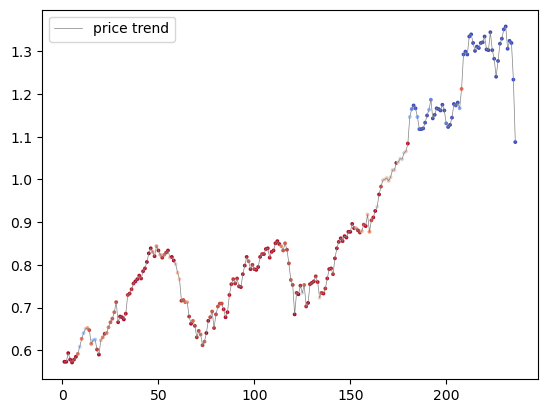

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.collections import LineCollection

action_list = []
price_list = []
n_list = []
index = 0
for n in X_test:
    action = policy.select_action(np.array(n))
    action_list.append(action)
    price_list.append(n[0])
    index +=1
    n_list.append(index)


# 製作figure  
fig = plt.figure()   

#圖表的設定
ax = fig.add_subplot(1, 1, 1)

#直線圖
ax.plot(n_list,price_list, color='grey',linewidth=0.5,label='price trend')
#散佈圖
norm = plt.Normalize(-1, 1)
ax.scatter(n_list, price_list, c=norm(action_list), cmap='coolwarm',s=3);
plt.legend()
plt.show()

# 紅色為正值 藍色為負值
# print('本次測試結果，將會賺得：' + str(money-100000) + '元(本金為100000)')

In [26]:
action_list[:]

[array([0.98514026], dtype=float32),
 array([0.9852126], dtype=float32),
 array([0.9971565], dtype=float32),
 array([0.9973749], dtype=float32),
 array([0.9970003], dtype=float32),
 array([0.95273274], dtype=float32),
 array([0.996435], dtype=float32),
 array([0.66524017], dtype=float32),
 array([-0.22234258], dtype=float32),
 array([0.6458989], dtype=float32),
 array([-0.2978787], dtype=float32),
 array([0.03400561], dtype=float32),
 array([0.4729993], dtype=float32),
 array([0.8199528], dtype=float32),
 array([0.6451355], dtype=float32),
 array([-0.32343873], dtype=float32),
 array([-0.31747216], dtype=float32),
 array([0.9072822], dtype=float32),
 array([0.9955931], dtype=float32),
 array([0.32550538], dtype=float32),
 array([0.5959248], dtype=float32),
 array([0.9468811], dtype=float32),
 array([0.62156147], dtype=float32),
 array([0.6343209], dtype=float32),
 array([0.7627515], dtype=float32),
 array([0.7874703], dtype=float32),
 array([0.745507], dtype=float32),
 array([0.8589666